Scanning image and building RGB cubes...


Rows processed: 100%|██████████| 321/321 [00:00<00:00, 957.41it/s]


Number of candidate colors (initc): 716
Number of sampled pixels for Stage 2 (SPN): 15596

================ EXISTING RGB ALGORITHM ================

[RGB] Initial palette generated (Stage 1) with 7 colors.
[RGB] Iteration 0: MSE1(0) = 926.44
[RGB] Iteration 1: MSE1(1) = 746.71
[RGB] Iteration 2: MSE1(2) = 733.66
[RGB] Iteration 3: MSE1(3) = 729.73
[RGB] Iteration 4: MSE1(4) = 727.71
[RGB] Iteration 5: MSE1(5) = 727.55
[RGB] Iteration 6: MSE1(6) = 727.48
[RGB] Iteration 7: MSE1(7) = 727.56
[RGB] Final palette generated (Stage 2) after 8 iterations.
Showing Existing RGB Palette swatch...
Plotting RGB cube with palette colors...


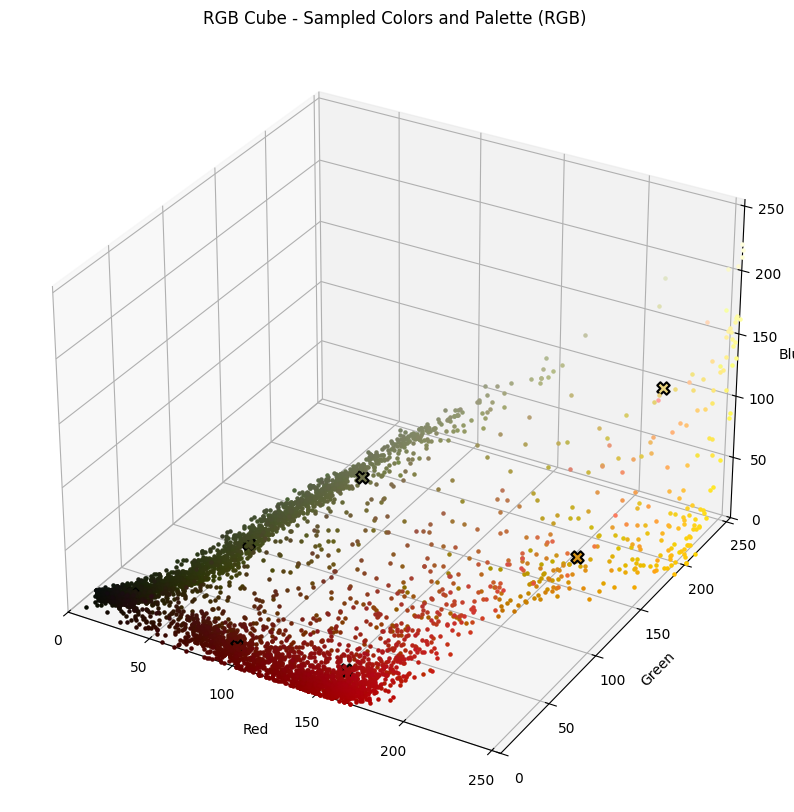

Plotting complete. Palette colors are marked as 'X'.

================ ENHANCED LAB ALGORITHM ================

Converting candidate colors and samples to CIELAB (Stage 0)...
[LAB] Initial perceptual palette (Stage 1 Enhanced) with 7 colors.
[LAB] Iteration 0: MSE1(0) = 125.99 (LAB space)
[LAB] Iteration 1: MSE1(1) = 100.75 (LAB space)
[LAB] Iteration 2: MSE1(2) = 99.58 (LAB space)
[LAB] Iteration 3: MSE1(3) = 99.08 (LAB space)
[LAB] Iteration 4: MSE1(4) = 98.79 (LAB space)
[LAB] Iteration 5: MSE1(5) = 98.64 (LAB space)
[LAB] Iteration 6: MSE1(6) = 98.56 (LAB space)
[LAB] Iteration 7: MSE1(7) = 98.52 (LAB space)
[LAB] Iteration 8: MSE1(8) = 98.51 (LAB space)
[LAB] Iteration 9: MSE1(9) = 98.50 (LAB space)
[LAB] Final perceptual palette after 10 iterations.
Showing Enhanced LAB Palette swatch...
Plotting RGB cube with palette colors...


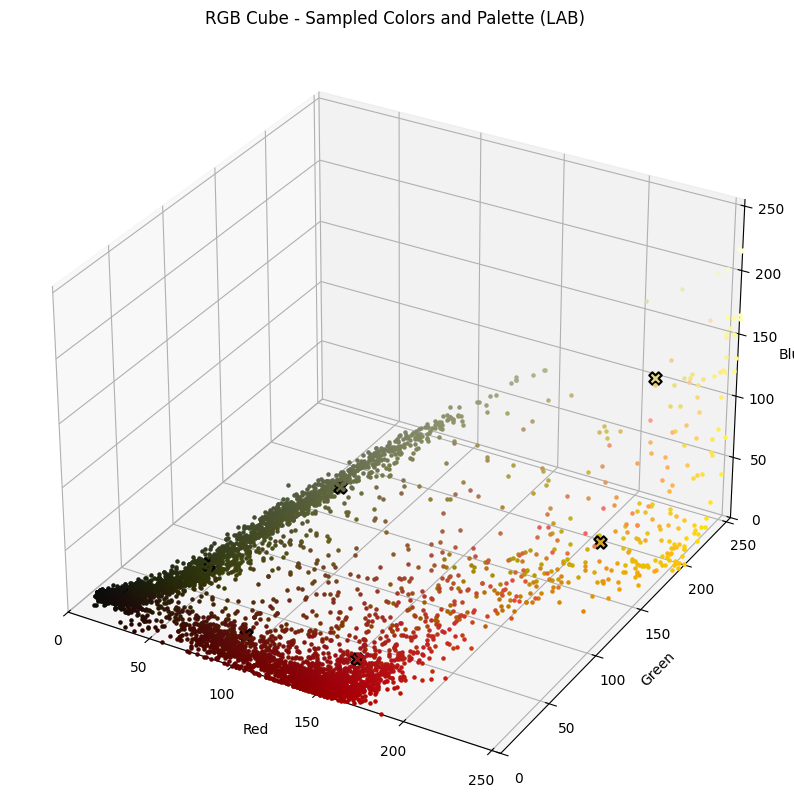

Plotting complete. Palette colors are marked as 'X'.


In [ ]:
# ============================================================
# Real-image visualization – RGB vs CIELAB K-Means Quantization
#  Original  |  Quantized (RGB K-Means)  |  Quantized (Lab K-Means)
#  + RGB and Lab palette swatches
# ============================================================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from skimage.color import rgb2lab, lab2rgb   # pip install scikit-image

# ------------- PARAMETERS ----------------

IMAGE_PATH = "flowers2.png"   # <-- change to your test image
K = 8                       # number of palette colors (7 or 8)
MAX_ITER = 10               # K-Means iterations
SEED = 1                    # for reproducibility

# ------------- HELPER FUNCTIONS (RGB) ----------------

def squared_euclidean(c1, c2):
    """Squared Euclidean distance in RGB."""
    dr = c1[0] - c2[0]
    dg = c1[1] - c2[1]
    db = c1[2] - c2[2]
    return dr*dr + dg*dg + db*db

def kmeans_rgb(pixels, K, max_iter=10, seed=None):
    """
    Plain K-Means in RGB using squared Euclidean distance.
    Returns: palette (list of (R,G,B)), mse_history (per iteration).
    """
    if seed is not None:
        random.seed(seed)

    N = len(pixels)
    if K > N:
        K = N

    centroids = [list(c) for c in random.sample(pixels, K)]
    mse_history = []

    for it in range(max_iter):
        clusters = [[] for _ in range(K)]
        mse_accum = 0.0

        # --- assignment step ---
        for (r, g, b) in pixels:
            dists = [squared_euclidean((r, g, b), (c[0], c[1], c[2]))
                     for c in centroids]
            k_idx = min(range(K), key=lambda i: dists[i])
            clusters[k_idx].append((r, g, b))
            mse_accum += dists[k_idx]

        mse = mse_accum / N
        mse_history.append(mse)
        print(f"[RGB] Iter {it}: MSE = {mse:.2f}")

        # --- update step ---
        for k in range(K):
            if clusters[k]:
                sr = sum(p[0] for p in clusters[k]) / len(clusters[k])
                sg = sum(p[1] for p in clusters[k]) / len(clusters[k])
                sb = sum(p[2] for p in clusters[k]) / len(clusters[k])
                centroids[k] = [int(sr), int(sg), int(sb)]
            # if empty cluster: keep old centroid

    palette = [tuple(c) for c in centroids]
    return palette, mse_history

def quantize_image_rgb(img, palette):
    """
    Quantize an image: each pixel -> nearest palette color (RGB Euclidean).
    """
    width, height = img.size
    out = Image.new("RGB", (width, height))
    pal = list(palette)

    for y in range(height):
        for x in range(width):
            c = img.getpixel((x, y))
            dists = [squared_euclidean(c, p) for p in pal]
            k_idx = min(range(len(pal)), key=lambda i: dists[i])
            out.putpixel((x, y), pal[k_idx])

    return out

# ------------- HELPER FUNCTIONS (CIELAB) ----------------

def rgb_list_to_lab_array(pixels):
    """
    Convert list of (R,G,B) 0–255 to an Nx3 Lab array.
    """
    arr = np.array(pixels, dtype=np.float32) / 255.0
    lab = rgb2lab(arr.reshape(-1, 1, 3)).reshape(-1, 3)
    return lab

def kmeans_lab(pixels_rgb, K, max_iter=10, seed=None):
    """
    K-Means in CIELAB space (perceptual distance).
    Returns:
      palette_rgb  - list of (R,G,B) centroids,
      mse_history  - Lab-space MSE per iteration,
      centroids_lab - Kx3 array of final Lab centroids.
    """
    rng = np.random.RandomState(seed)

    pixels_lab = rgb_list_to_lab_array(pixels_rgb)
    N = pixels_lab.shape[0]
    if K > N:
        K = N

    # random init in Lab
    init_idx = rng.choice(N, size=K, replace=False)
    centroids = pixels_lab[init_idx].copy()

    mse_history = []

    for it in range(max_iter):
        clusters = [[] for _ in range(K)]
        mse_accum = 0.0

        # assignment in Lab
        for lab_col in pixels_lab:
            dists = np.sum((centroids - lab_col) ** 2, axis=1)
            k_idx = int(np.argmin(dists))
            clusters[k_idx].append(lab_col)
            mse_accum += float(dists[k_idx])

        mse = mse_accum / N
        mse_history.append(mse)
        print(f"[Lab] Iter {it}: MSE_Lab = {mse:.2f}")

        # update in Lab
        for k in range(K):
            if clusters[k]:
                centroids[k] = np.mean(clusters[k], axis=0)

    # convert final centroids back to RGB for visualization
    rgb_centroids = lab2rgb(centroids.reshape(-1, 1, 3)).reshape(-1, 3)
    rgb_centroids = np.clip(rgb_centroids * 255.0, 0, 255).astype(np.uint8)
    palette_rgb = [tuple(int(v) for v in row) for row in rgb_centroids]

    return palette_rgb, mse_history, centroids

def quantize_image_lab(img, centroids_lab, palette_rgb):
    """
    Quantize an image using Lab centroids (distance in Lab, output in RGB).
    """
    arr_rgb = np.array(img, dtype=np.float32) / 255.0
    h, w, _ = arr_rgb.shape
    arr_lab = rgb2lab(arr_rgb)

    pal_rgb = np.array(palette_rgb, dtype=np.float32) / 255.0
    K = centroids_lab.shape[0]

    out_rgb = np.zeros_like(arr_rgb)

    for y in range(h):
        for x in range(w):
            lab_vec = arr_lab[y, x, :]
            dists = np.sum((centroids_lab - lab_vec) ** 2, axis=1)
            k = int(np.argmin(dists))
            out_rgb[y, x, :] = pal_rgb[k]

    out_img = Image.fromarray(
        np.clip(out_rgb * 255.0, 0, 255).astype(np.uint8), mode="RGB"
    )
    return out_img

# ------------- SWATCH HELPER ----------------

def make_swatch_image(palette, swatch_height=80, swatch_width_per_color=40):
    """
    Build a horizontal palette swatch image from a list of (R,G,B).
    """
    if not palette:
        return None

    w = swatch_width_per_color * len(palette)
    h = swatch_height
    swatch = Image.new("RGB", (w, h))

    for i, color in enumerate(palette):
        for x in range(i * swatch_width_per_color,
                       (i + 1) * swatch_width_per_color):
            for y in range(h):
                swatch.putpixel((x, y), color)

    return swatch

# ------------- MAIN EXPERIMENT ----------------

if __name__ == "__main__":
    # 1) Load image and convert to RGB
    orig_img = Image.open(IMAGE_PATH).convert("RGB")
    width, height = orig_img.size

    # 2) Flatten pixels for K-Means
    pixels = [orig_img.getpixel((x, y))
              for y in range(height)
              for x in range(width)]
    print(f"Total pixels: {len(pixels)}")

    # 3) Run K-Means in RGB
    print(f"\nRunning K-Means in RGB with K={K} ...")
    palette_rgb, mse_hist_rgb = kmeans_rgb(
        pixels, K=K, max_iter=MAX_ITER, seed=SEED
    )
    final_mse_rgb = mse_hist_rgb[-1]
    print(f"\nFinal MSE (RGB space): {final_mse_rgb:.2f}")

    # 4) Run K-Means in Lab
    print(f"\nRunning K-Means in CIELAB with K={K} ...")
    palette_lab_rgb, mse_hist_lab, centroids_lab = kmeans_lab(
        pixels, K=K, max_iter=MAX_ITER, seed=SEED
    )
    final_mse_lab = mse_hist_lab[-1]
    print(f"\nFinal MSE (Lab space): {final_mse_lab:.2f}")

    # 5) Quantize the image using both palettes
    quant_img_rgb = quantize_image_rgb(orig_img, palette_rgb)
    quant_img_lab = quantize_image_lab(orig_img, centroids_lab, palette_lab_rgb)

    # 6) Build palette swatch images
    swatch_rgb = make_swatch_image(palette_rgb)
    swatch_lab = make_swatch_image(palette_lab_rgb)

    # 7) Plot:
    # Row 1: Original | RGB-quantized | RGB swatch
    # Row 2: (blank left) | Lab-quantized | Lab swatch
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # --- Row 1 ---
    axes[0, 0].imshow(np.array(orig_img))
    axes[0, 0].set_title("Original image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(np.array(quant_img_rgb))
    axes[0, 1].set_title(f"Quantized (RGB K-Means, K={K})\nMSE_RGB={final_mse_rgb:.1f}")
    axes[0, 1].axis("off")

    if swatch_rgb is not None:
        axes[0, 2].imshow(np.array(swatch_rgb))
    axes[0, 2].set_title("RGB palette swatch")
    axes[0, 2].axis("off")

    # --- Row 2 ---
    # empty bottom-left panel
    axes[1, 0].axis("off")

    # Lab-quantized image with note underneath
    axes[1, 1].imshow(np.array(quant_img_lab))
    axes[1, 1].set_title(f"Quantized (Lab K-Means, K={K})\nMSE_Lab={final_mse_lab:.1f}",
                         fontsize=10)
    axes[1, 1].axis("off")
    axes[1, 1].text(
        0.5, -0.12,
        "Distances are computed in perceptual CIELAB space.",
        ha="center", va="top", transform=axes[1, 1].transAxes, fontsize=9
    )

    # Lab palette swatch
    if swatch_lab is not None:
        axes[1, 2].imshow(np.array(swatch_lab))
    axes[1, 2].set_title("Lab-based palette swatch")
    axes[1, 2].axis("off")

    plt.suptitle(
        "Real-image visualization: RGB Fast K-Means vs CIELAB Fast K-Means",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()